# Compute the dose in a water phantom

Compute the dose at various depths and off-axis positions in a water phantom
with a 10x10cm² square field. Uses a plane surface, located at SAD.

Computes the dose for three dose profiles:
- The depth-dose curve along the central axis
- The off-axis profile at a depth of 100 mm
- A 2D dose distribution

In [1]:
using Pkg; Pkg.activate("."); Pkg.instantiate()
using Roentgen
using Plots, StaticArrays
using SparseArrays, Printf

  Activating project at `~/Code/Roentgen.jl/examples`


## Dose Calculation Setup

Set the fieldsize, source-axis distance (SAD), source-surface distance (SSD), and position the gantry:

In [2]:
fieldsize = 100.
SAD = 1000.
SSD = SAD

gantry = GantryPosition(0., 0., SAD);

From this, we can greate a grid of beamlets:

In [3]:
xb = -0.5*fieldsize:5:0.5*fieldsize
bixels = BixelGrid(xb, xb)
beamlets = Beamlet.(bixels, (gantry,));

Set up the dose calculation algorithm. We'll calibrate such that at the given fieldsize, 100 MU gives 1 Gy at max dose:

In [4]:
calc = FinitePencilBeamKernel("/path/to/kernel-data.jld2")

# Calibrate: 100 MU at maximum with field size of 100 mm and SSD of 1000. mm
MU = 100.
calibrate!(calc, MU, fieldsize, SSD);

Finally, we'll create an external surface at the SSD:

In [5]:
surf = PlaneSurface(SSD)

PlaneSurface{Float64}(1000.0)

## Depth Dose

To compute the dose along the central beam axis, we generate points along this line:

In [6]:
depth = 0.:1.:500
pos = SVector.(0., 0., -depth);

Then compute dose:

In [7]:
dose = sum(dose_fluence_matrix(Matrix, pos, beamlets, surf, calc); dims=2);

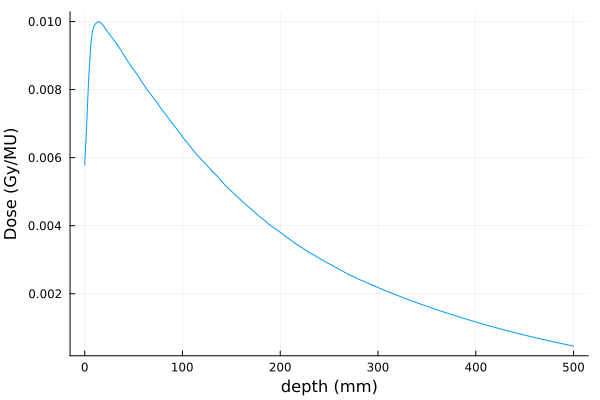

In [8]:
plot(depth, dose, xlabel="depth (mm)", ylabel="Dose (Gy/MU)", legend=false, fmt=:png)

## Off-Axis Profiles

Similar to the z dose example, we can create off-axis profiles at various depths:

In [9]:
depth = 50.:50:250
x = -300:2:300
pos = SVector.(x, 0., -depth');

In [10]:
dose = sum(dose_fluence_matrix(Matrix, pos, beamlets, surf, calc); dims=2)
dose = reshape(dose, size(pos));

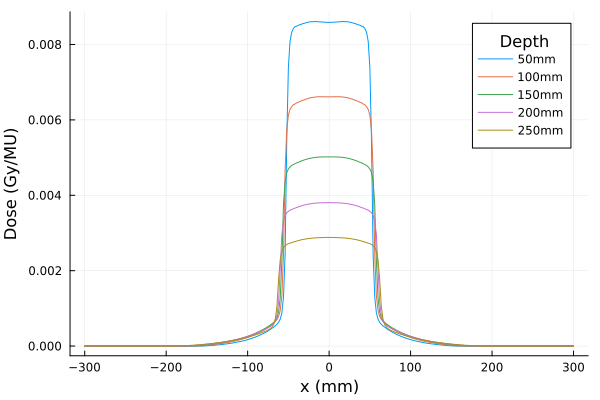

In [11]:
plt = plot(xlabel="x (mm)", ylabel="Dose (Gy/MU)", legendtitle="Depth")
for i in eachindex(depth)
    plot!(plt, x, dose[:, i], label=@sprintf "%0.0fmm" depth[i])
end
plot!(plt; fmt=:png)

## 3D Dose

Finally, we can compute the full 3D dose distribution by placing a grid of points.

*Note:* This is quite a computationally intensive task, so depending on hardware may take a while to compute. Also check the number of threads that Julia has been launched with.

In [12]:
Δ = 5.
x = -200.:Δ:200.
y = -200.:Δ:200.
z = -400.:Δ:0.
pos = DoseGrid(x, y, z);

In [13]:
dose = sum(dose_fluence_matrix(Matrix, vec(pos), vec(beamlets), surf, calc); dims=2);
dose = reshape(Array(dose), size(pos));

We can plot slices:

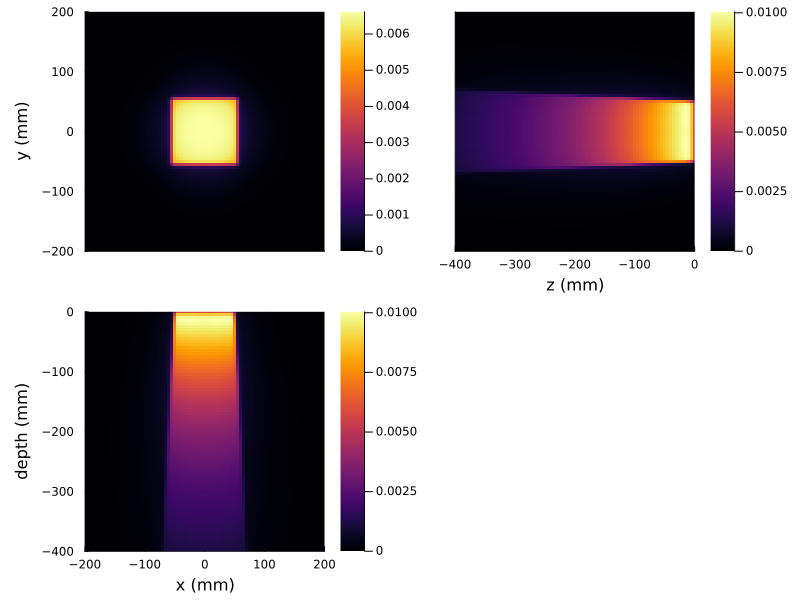

In [14]:
depth = -z;

k = searchsortedlast(z, -100.)
plt_xy = plot(ylabel="y (mm)", xticks=[])
heatmap!(plt_xy, x, y, dose[:, :, k]', aspect_ratio=1,
         xlim=x[[1,end]], ylim=y[[1, end]])

i = searchsortedlast(x, 0.)
plt_yz = plot(xlabel="z (mm)", yticks=[])
heatmap!(plt_yz, z, y, dose[i, :, :], aspect_ratio=1,
         xlim=z[[1,end]], ylim=y[[1, end]])

j = searchsortedlast(y, 0.)
plt_xz = plot(xlabel="x (mm)", ylabel="depth (mm)")
heatmap!(plt_xz, x, z, dose[:, j, :]', aspect_ratio=1,
         xlim=x[[1,end]], ylim=z[[1, end]])

plot(plt_xy, plt_yz, plt_xz, layout=(2, 2), size=(800, 600); fmt=:png)

Or we can save to file for visualisation in other software, such as Slicer or Paraview:

In [15]:
# To VTK (Paraview)
write_vtk("water-tank", pos, "dose"=>dose)
# To NRRD (Slicer)
write_nrrd("water-tank.nrrd", pos, dose);